# Test trained model(s)

In [1]:
######################################
#Script to test and log trained model#
#Maintainer: Christopher Chan        #
#Version: 0.3.1                      #
#Date: 2022-04-04                    #
######################################

import os
import sys
import torch
import random
import re
import tqdm
from dataloader import BuildingDataset
import numpy as np
import torchvision.models as models
import segmentation_models_pytorch as smp
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from Networks import Five_UNet, Four_UNet
from torchvision import transforms
from PIL import Image
from scipy import ndimage

%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/")
Four_UNet = Four_UNet()

In [4]:
TestIMG_ls = []
TestLBL_ls = []

for root, dirs, filename in os.walk(os.path.join(data_path, "Test_15cm", "IMG")):
    for i in filename:
        #if i.startswith("KBY15_IMG"):
            TestIMG_ls.append(root + "/" + i)

for i in TestIMG_ls:
    i = re.sub("IMG", "LBL", i, count = 2)
    TestLBL_ls.append(i)

Test = BuildingDataset(png_dir = TestIMG_ls,
                       lbl_dir = TestLBL_ls)

assert len(Test.png_dir) == len(Test.lbl_dir)

print("Concatenated TESTING images: {0} and labels pair: {0} :".format(len(Test.png_dir)))
for x, y in zip(Test.png_dir, Test.lbl_dir):
    print(f"Image: {x}", f"Label: {y}")


Concatenated TESTING images: 611 and labels pair: 611 :
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_8037-3933.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_8037-3933.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_31293-24624.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_31293-24624.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_5643-5301.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_5643-5301.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_7182-3249.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_7182-3249.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_1881-13680.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_1881-13680.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_10260-3249.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_102

<class 'torch.Tensor'>


Text(0.5, 1.0, 'LBL')

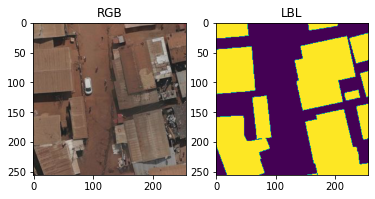

In [8]:
# plot a sample
test = BuildingDataset(TestIMG_ls, TestLBL_ls, transform = None)
test_pair = random.choice(test)

print(type(test_pair[0]))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(test_pair[0].cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(test_pair[1].cpu().numpy().transpose(1, 2, 0))
ax.set_title('LBL')

### Vanilla Four layer U-Net Baseline

In [4]:
weights_4UNet = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY3969:462_256oc1_Four-Unet_lr1e-3_wd1e-5_b32_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_051155.pth"))
weights_4UNet = torch.load(weights_4UNet, map_location = device)
Four_UNet.load_state_dict(weights_4UNet["Model:"])
Four_UNet.to(device = device)

print(sum(p.numel() for p in Four_UNet.parameters() if p.requires_grad == True))

7763041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 5.302134553630822e-08, Maximum: 0.007054563611745834, Mean: 0.0007160933455452323, St dev: 0.0013538893545046449
True Positive = 47.270591735839844, True Negative = 53182.65625 False Negative = 3.3450982570648193, False Positive = 12302.7294921875
Precision = 0.0038275783881545067, Recall = 0.9339118599891663, Specificity = 0.8121301531791687 Overall Accuracy = 0.8122242093086243, Intersection-over-Union = 0.0038265420589596033


Text(0.5, 1.0, 'Binary Segmentation')

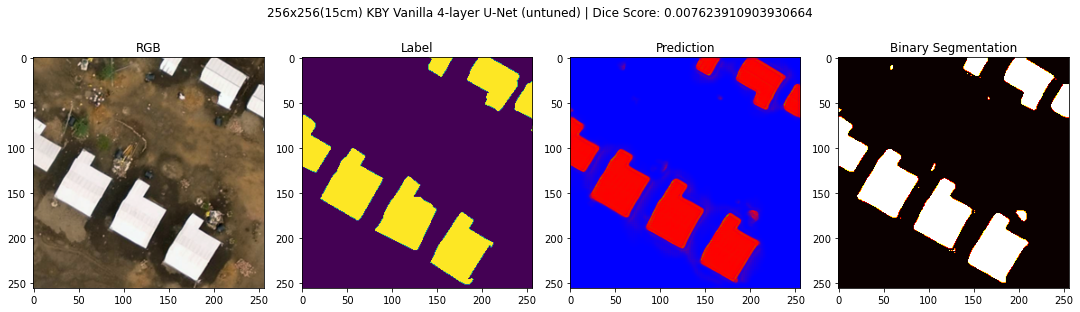

In [5]:
Four_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = Four_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()
    
    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}".format(Precision, Recall, Specificity, OA, IoU))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY Vanilla 4-layer U-Net (untuned) | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### Qubvel OpenCities EB1-UNet

In [6]:
qubvelEB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
qubvel_weights = torch.load(qubvel_weights, map_location = device)
qubvelEB1_UNet.load_state_dict(qubvel_weights["state_dict"])
qubvelEB1_UNet.to(device = device)

print(sum(p.numel() for p in qubvelEB1_UNet.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 1.2216580835958913e-18, Maximum: 1.0, Mean: 0.16909262537956238, St dev: 0.37361159920692444
True Positive = 44.74117660522461, True Negative = 54037.125 False Negative = 5.874509811401367, False Positive = 11448.259765625
Precision = 0.0038929064758121967, Recall = 0.8839389681816101, Specificity = 0.8251784443855286 Overall Accuracy = 0.8252238035202026, Intersection-over-Union = 0.0038909176364541054


Text(0.5, 1.0, 'Binary Segmentation')

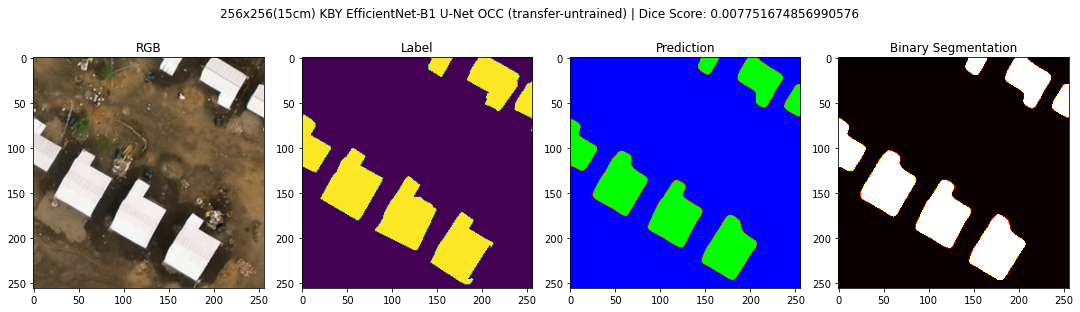

In [7]:
qubvelEB1_UNet.eval()

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = qubvelEB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}".format(Precision, Recall, Specificity, OA, IoU))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet-B1 U-Net OCC (transfer-untrained) | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet Vanilla (No ImageNet) Baseline

In [8]:
EB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

EB1_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY3969:462_256oc1_EB1-UNet-NoIMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_027955.pth"))
EB1_weights = torch.load(EB1_weights, map_location = device)
EB1_UNet.load_state_dict(EB1_weights["Model:"])
EB1_UNet.to(device = device)

print(sum(p.numel() for p in EB1_UNet.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 2.42968155816925e-07, Maximum: 0.006194777321070433, Mean: 0.0006512140389531851, St dev: 0.0012862166622653604
True Positive = 47.90195846557617, True Negative = 52812.2890625 False Negative = 2.7137255668640137, False Positive = 12673.099609375
Precision = 0.0037655807100236416, Recall = 0.9463856816291809, Specificity = 0.8064743876457214 Overall Accuracy = 0.806582510471344, Intersection-over-Union = 0.0037647776771336794


Text(0.5, 1.0, 'Binary Segmentation')

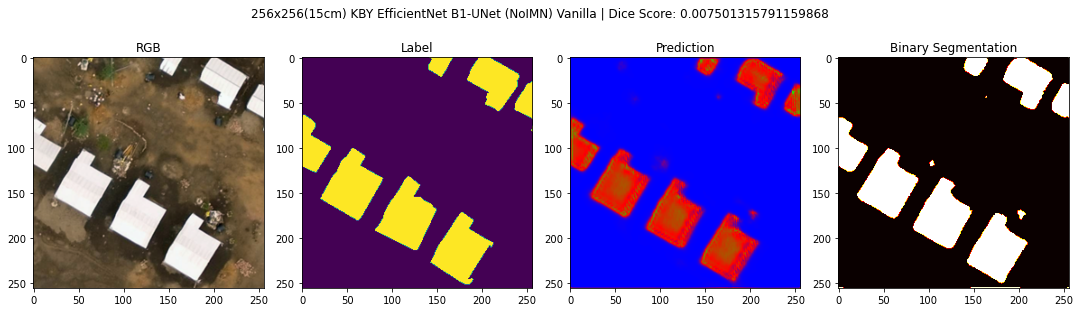

In [9]:
EB1_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}".format(Precision, Recall, Specificity, OA, IoU))


# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet B1-UNet (NoIMN) Vanilla | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet ImageNet (trained-untuned) Baseline

In [11]:
EB1_UNet_IMN = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

IMN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "20713:5094_256oc1_EB1-Unet-IMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_324647.pth"))
IMN_weights = torch.load(IMN_weights, map_location = device)
EB1_UNet_IMN.load_state_dict(IMN_weights["Model:"])
EB1_UNet_IMN.to(device = device)

print(sum(p.numel() for p in EB1_UNet_IMN.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 3.1017962101032026e-06, Maximum: 0.005529558286070824, Mean: 0.0016335875261574984, St dev: 0.0014122180873528123
True Positive = 117.05097961425781, True Negative = 30556.244140625 False Negative = 15.756863594055176, False Positive = 34846.94921875
Precision = 0.00334775703959167, Recall = 0.881355881690979, Specificity = 0.46719804406166077 Overall Accuracy = 0.46803733706474304, Intersection-over-Union = 0.003346248995512724


Text(0.5, 1.0, 'Binary Segmentation')

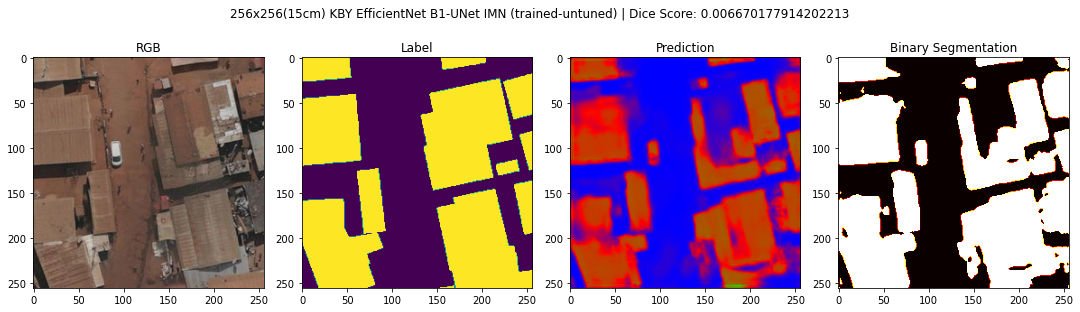

In [12]:
EB1_UNet_IMN.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_IMN(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}".format(Precision, Recall, Specificity, OA, IoU))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B1-UNet IMN (trained-untuned) | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet OCC (transfer-trained) Baseline

In [12]:
EB1_UNet_OCCtrans = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

OCCtrans_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY3969:462_256oc1_EB1-Unet-qubvel_lr1e-4_wd1e-5_b16_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_108800.pth"))
OCCtrans_weights = torch.load(OCCtrans_weights, map_location = device)
EB1_UNet_OCCtrans.load_state_dict(OCCtrans_weights["Model:"])
EB1_UNet_OCCtrans.to(device = device)

print(sum(p.numel() for p in EB1_UNet_OCCtrans.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 5.464664293551049e-16, Maximum: 0.029402591288089752, Mean: 0.0006905652116984129, St dev: 0.0014521977864205837
True Positive = 47.56470489501953, True Negative = 52855.953125 False Negative = 3.050980567932129, False Positive = 12629.435546875
Precision = 0.0037520474288612604, Recall = 0.9397226572036743, Specificity = 0.807141125202179 Overall Accuracy = 0.8072435259819031, Intersection-over-Union = 0.0037511447444558144


Text(0.5, 1.0, 'Binary Segmentation')

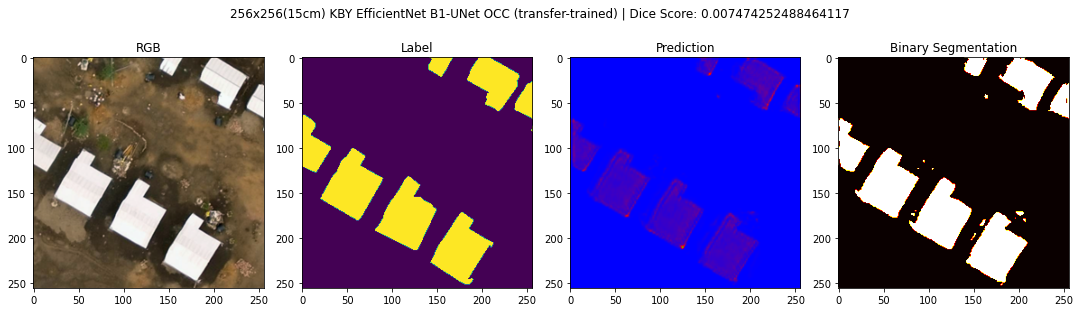

In [13]:
EB1_UNet_OCCtrans.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_OCCtrans(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}".format(Precision, Recall, Specificity, OA, IoU))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet B1-UNet OCC (transfer-trained) | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')